In [1]:

# Import required Libaries
import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models, layers, regularizers
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [2]:
import pandas as pd
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
import numpy as np
# normalization of data
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,StratifiedKFold,GridSearchCV
from matplotlib import pyplot  as plt

In [3]:
# Load the Datasets
df_train=pd.read_csv("aps_failure_training_set.csv",skiprows=20)
df_test=pd.read_csv("aps_failure_test_set.csv",skiprows=20)

In [4]:
# replace the class col from from categorical to binary numerical form
df_test["class"]=df_test["class"].replace({"neg":0,"pos":1})
df_train["class"]=df_train["class"].replace({"neg":0,"pos":1})

In [5]:
# replace np with NAN
df_train.replace({"na":np.NAN},inplace=True)
df_test.replace({"na":np.NAN},inplace=True)

In [6]:
# change column datatype from object to float
df_train=df_train.astype(float)
df_test=df_test.astype(float)

In [7]:
# drop the null values and save to new frame df_tr_null
df_tr_null=df_train.dropna()
df_test_null=df_test.dropna()

In [8]:
# Prepare the data inot X and y
df_tr_x=df_tr_null.drop("class",axis=1)
df_tr_y=df_tr_null["class"]


testx=df_test_null.drop("class",axis=1)
testy=df_test_null["class"]


In [9]:
Normalize=preprocessing.StandardScaler()

In [10]:
df_tr_x=pd.DataFrame(Normalize.fit_transform(df_tr_x))
testx=pd.DataFrame(Normalize.fit_transform(testx))

In [11]:
print(df_tr_x.shape)

(591, 170)


In [12]:
# K_fold method
k_fold=StratifiedKFold(n_splits=5,shuffle=True)

In [66]:

def compare_val_loss(dataframe1,dataframe2):
    plt.plot(dataframe1['epochs'][10:],dataframe1["val_loss"][10:], "k-", linewidth=2, label="base_model validation_loss")
    plt.plot(dataframe1['epochs'][10:],dataframe1["loss"][10:], "b-", linewidth=2, label="base_model training_loss")
    plt.plot(dataframe2['epochs'][10:],dataframe2["val_loss"][10:], "r-", linewidth=2, label="high_model validation_loss")
    plt.plot(dataframe2['epochs'][10:],dataframe2["loss"][10:], "g-", linewidth=2, label="high_model training_loss")
    plt.title("Validation loss and Training loss comparison")
    plt.xlabel("epochs")
    plt.ylabel("Validation_loss")
    plt.legend()
    plt.plot()

In [67]:
# plo the accuracy of model
def compare_accuracy_curve(dataframe1,dataframe2):
    plt.plot(dataframe1['epochs'][10:],dataframe1["val_accuracy"][10:], "k-", linewidth=2, label="base_model val_accuracy")
    plt.plot(dataframe1['epochs'][10:],dataframe1["accuracy"][10:], "b-", linewidth=2, label="base_model training_accuracy")
    plt.plot(dataframe2['epochs'][10:],dataframe2["val_accuracy"][10:], "r-", linewidth=2, label="high_model val_accuracy")
    plt.plot(dataframe2['epochs'][10:],dataframe2["accuracy"][10:], "g-", linewidth=2, label="high_model training_accuracy")
    plt.title("Validation accuracy and Training accuracy calculation")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.legend()
    plt.plot()

In [17]:
def B_model():
    model = models.Sequential()
    model.add(layers.Dense(60, input_shape=(170,), activation='relu'))
    model.add(layers.Dense(30, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model    



In [18]:
def BN_model():
    model=models.Sequential()
    model.add(layers.Dense(60, input_shape=(170,), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(30,activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1,activation="sigmoid"))
    # compile the model
    model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
    return model
    

In [53]:
# Training the model using training data and validating it performance using validation dataset
for train_index,cv_index in k_fold.split(df_tr_x,df_tr_y):
    
    train_x_fold, x_cv_fold = df_tr_x.iloc[train_index,:], df_tr_x.iloc[cv_index,:]
    train_y_fold, y_cv_fold = df_tr_y.iloc[train_index], df_tr_y.iloc[cv_index]

    # When model fails to convert data from datafraem to tensor, so we convert first the to array
    train_x_fold=np.asarray(train_x_fold).astype(np.float32)
    train_y_fold=np.asarray(train_y_fold).astype(np.float32)
    x_cv_fold=np.asarray(x_cv_fold).astype(np.float32)
    y_cv_fold=np.asarray(y_cv_fold).astype(np.float32)

    # call the models
    base_model=B_model()
    high_model=BN_model()

    
    history1=base_model.fit(train_x_fold,train_y_fold,batch_size=300,epochs=100,validation_data=(x_cv_fold,y_cv_fold),verbose=0)
    history2=high_model.fit(train_x_fold,train_y_fold,batch_size=300,epochs=100,validation_data=(x_cv_fold,y_cv_fold),verbose=0)


df1=pd.DataFrame(history1.history)
df1["epochs"]=history1.epoch


df_BN=pd.DataFrame(history2.history)
df_BN["epochs"]=history2.epoch
    

In [56]:
# predcition on the test data
predict_base=base_model.predict(testx)
predict_base=predict_base>0.5
predict_base_BN=high_model.predict(testx)
predict_base_BN=predict_base_BN>0.5

6/6 [==============================] - 0s 3ms/step


In [57]:
# print the classification report and it for B_model
print(classification_report(testy,predict_base))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       135
         1.0       1.00      0.90      0.95        30

    accuracy                           0.98       165
   macro avg       0.99      0.95      0.97       165
weighted avg       0.98      0.98      0.98       165



In [22]:
# classification report for the model BN_model
print(classification_report(testy,predict_base_BN))

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       135
         1.0       1.00      0.80      0.89        30

    accuracy                           0.96       165
   macro avg       0.98      0.90      0.93       165
weighted avg       0.97      0.96      0.96       165



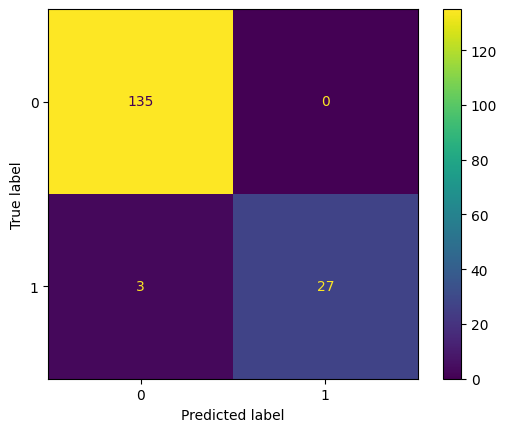

In [58]:
# confusion matrix for the B_model
cm=confusion_matrix(testy,predict_base)
disp=ConfusionMatrixDisplay(cm)
disp.plot()

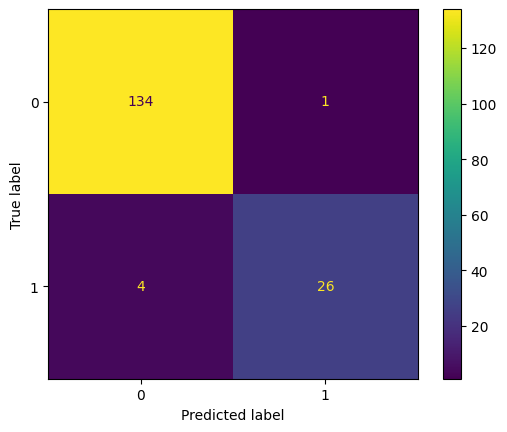

In [59]:
# confusion matrix for the BN_model
cm=confusion_matrix(testy,predict_base_BN)
disp_=ConfusionMatrixDisplay(cm)
disp_.plot()

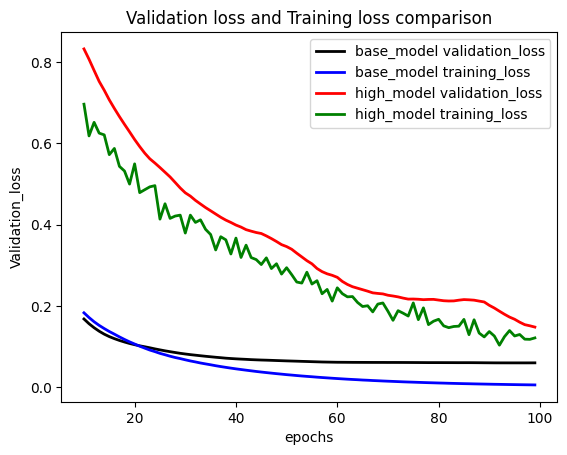

In [68]:

compare_val_loss(df1,df_BN)

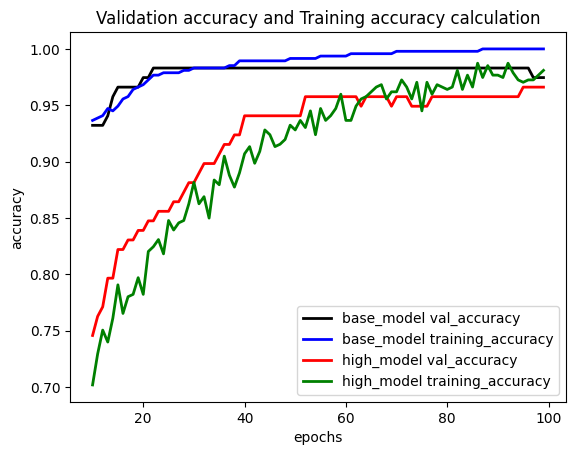

In [69]:
compare_accuracy_curve(df1,df_BN)

# Comment on above models


Base model and High Model
Looking at the validation loss and training loss curve, also validation_accuracy and traininng accuarcy vs epochs. Both of the model has shown efficient performance.

The base model has high accuarcy as well as the high f1-score so that could be the best model to use.


## Try different model with 

In [70]:

def model1():

    model=models.Sequential()
    model.add(layers.Dense(128,activation="relu",input_shape=(df_tr_x.shape[1],)))
    #model.add(layers.Dropout(0.5))
    model.add(layers.Dense(118,activation="relu"))
    #model.add(layers.Dropout(0.5))
    # model.add(layers.Dense(88,activation="relu"))
    # model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64,activation="relu"))
    #model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32,activation="relu"))
    #model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1,activation="sigmoid"))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    return model

def model2():

    model=models.Sequential()
    model.add(layers.Dense(128,activation="elu",input_shape=(df_tr_x.shape[1],)))
    #model.add(layers.Dropout(0.5))
    model.add(layers.Dense(118,activation="elu"))
    #model.add(layers.Dropout(0.5))
    # model.add(layers.Dense(88,activation="relu"))
    # model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64,activation="elu"))
    #model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32,activation="elu"))
    #model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1,activation="sigmoid"))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [71]:
# Training the model using training data and validating it performance using validation dataset
for train_index,cv_index in k_fold.split(df_tr_x,df_tr_y):
    
    train_x_fold, x_cv_fold = df_tr_x.iloc[train_index,:], df_tr_x.iloc[cv_index,:]
    train_y_fold, y_cv_fold = df_tr_y.iloc[train_index], df_tr_y.iloc[cv_index]

    # When model fails to convert data from datafraem to tensor, so we convert first the to array
    train_x_fold=np.asarray(train_x_fold).astype(np.float32)
    train_y_fold=np.asarray(train_y_fold).astype(np.float32)
    x_cv_fold=np.asarray(x_cv_fold).astype(np.float32)
    y_cv_fold=np.asarray(y_cv_fold).astype(np.float32)

    # call the models
    base_model=model1()
    high_model=model2()

    
    history1=base_model.fit(train_x_fold,train_y_fold,batch_size=300,epochs=100,validation_data=(x_cv_fold,y_cv_fold),verbose=0)
    history2=high_model.fit(train_x_fold,train_y_fold,batch_size=300,epochs=100,validation_data=(x_cv_fold,y_cv_fold),verbose=0)


df_rms=pd.DataFrame(history1.history)
df_rms["epochs"]=history1.epoch


df_adam=pd.DataFrame(history2.history)
df_adam["epochs"]=history2.epoch
    

In [72]:
# predcition on the test data
predict_base=base_model.predict(testx)
predict_base=predict_base>0.5
predict_base_BN=high_model.predict(testx)
predict_base_BN=predict_base_BN>0.5

6/6 [==============================] - 0s 2ms/step


In [73]:
# print the classification report and it for B_model
print(classification_report(testy,predict_base))

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97       135
         1.0       0.96      0.77      0.85        30

    accuracy                           0.95       165
   macro avg       0.95      0.88      0.91       165
weighted avg       0.95      0.95      0.95       165



In [74]:
# classification report for the model BN_model
print(classification_report(testy,predict_base_BN))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       135
         1.0       0.96      0.87      0.91        30

    accuracy                           0.97       165
   macro avg       0.97      0.93      0.95       165
weighted avg       0.97      0.97      0.97       165



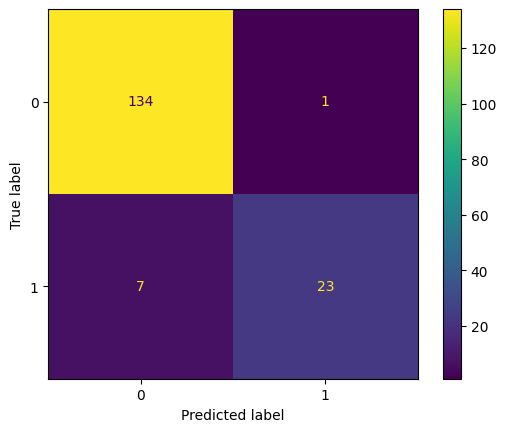

In [75]:
# confusion matrix for the B_model
cm=confusion_matrix(testy,predict_base)
disp=ConfusionMatrixDisplay(cm)
disp.plot()

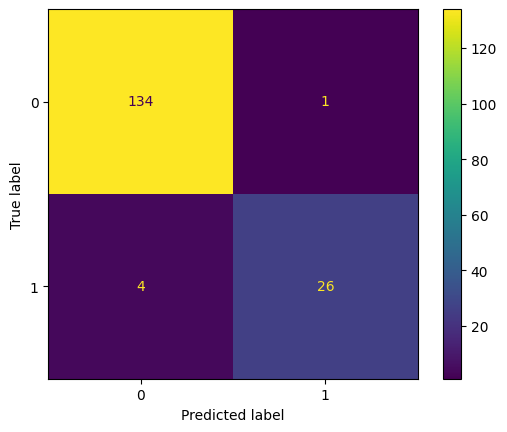

In [76]:
# confusion matrix for the BN_model
cm=confusion_matrix(testy,predict_base_BN)
disp_=ConfusionMatrixDisplay(cm)
disp_.plot()

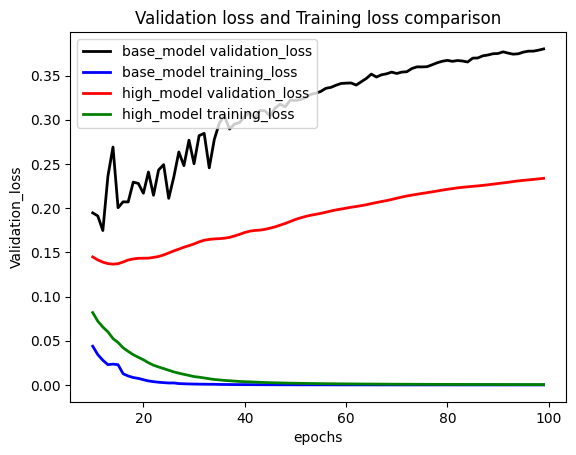

In [78]:

compare_val_loss(df_rms,df_adam)


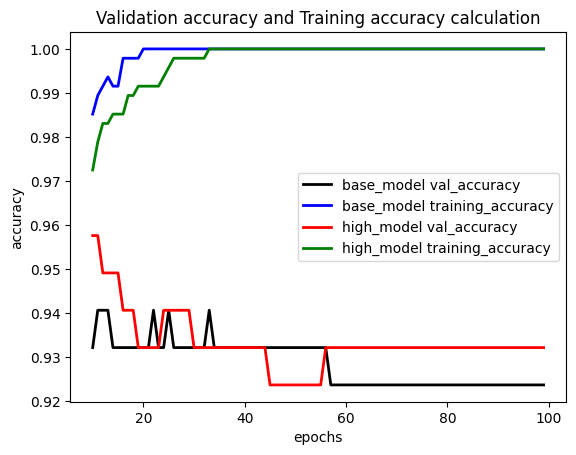

In [79]:
compare_accuracy_curve(df_rms,df_adam)

# comment on complex models
Looking at the validation loss and trainining loss, one understand the models is overfitting. although it has shown good performace.

# Third Approach: Median Imputation

In [13]:
data=pd.DataFrame(df_train.isnull().sum().nlargest(7))
data1=pd.DataFrame(df_test.isnull().sum().nlargest(7))

data1.reset_index(inplace=True)
data.reset_index(inplace=True)

In [14]:
df_median_train=df_train.drop(np.asarray(data["index"]),axis=1)
df_median_test=df_test.drop(np.asarray(data1["index"]),axis=1)

In [15]:
# dataframes filled with median values 
df_median_train=df_median_train.fillna(df_median_train.median())
df_median_test=df_median_test.fillna(df_median_test.median())

In [16]:
# split data inot x and y
data_trmedian_x=df_median_train.drop(["class"],axis=1)
data_trmedian_y=df_median_train["class"]

data_temedian_x=df_median_test.drop(["class"],axis=1)
data_temedian_y=df_median_test["class"]

In [17]:
data_trmedian_x=pd.DataFrame(Normalize.fit_transform(data_trmedian_x))
data_temedian_x=pd.DataFrame(Normalize.fit_transform(data_temedian_x))

# Implementation using the Base Model

## Implementation of logistic regression with dataset imputated with median

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss,confusion_matrix,ConfusionMatrixDisplay,accuracy_score,classification_report,precision_recall_curve,average_precision_score,auc,roc_curve

In [19]:
# Hyperparameters:
penalty = 'l2'
C = 1.0 #regularization strength. The smaller the value, the stronger the regularization.
random_state = 2021
solver = 'liblinear' # For small datasets, it is good.
logReg = LogisticRegression(penalty=penalty, C=C,random_state=random_state, solver=solver)

In [20]:
trainx,trainy=data_trmedian_x,data_trmedian_y

In [21]:
TotalPredictPro=pd.DataFrame(data=[],index=trainy.index,columns=[0,1])
Score_train=[]
Score_cv=[]
for train_index,cv_index in k_fold.split(trainx,trainy):
    train_x_fold, x_cv_fold = trainx.iloc[train_index,:], trainx.iloc[cv_index,:]
    train_y_fold, y_cv_fold = trainy.iloc[train_index], trainy.iloc[cv_index]

    logReg.fit(train_x_fold,train_y_fold)

    predictpro_tr=logReg.predict_proba(train_x_fold)  # predict_proba is confidence score of detected value be;ongs to perticular class
    entropy_loss_tr=log_loss(train_y_fold,predictpro_tr)
    Score_train.append(entropy_loss_tr)


    predictpro_val=logReg.predict_proba(x_cv_fold)
    entropy_loss_val=log_loss(y_cv_fold,predictpro_val)
    Score_cv.append(entropy_loss_val)


    TotalPredictPro.loc[x_cv_fold.index,:] =logReg.predict_proba(x_cv_fold)


    print("******************************************************")
    print(f"The log_loss on training dataset is { entropy_loss_tr}")
    print(f"The log_loss on training dataset is { entropy_loss_val}")

print("**********************************************")
predicty=logReg.predict_proba(trainx)
total_entropy_loss=log_loss(trainy,predicty)

print(f"Total log_loss given as {total_entropy_loss}")


******************************************************
The log_loss on training dataset is 0.024464146916115204
The log_loss on training dataset is 0.029404641464361926
******************************************************
The log_loss on training dataset is 0.024675091422145266
The log_loss on training dataset is 0.027947321511070565
******************************************************
The log_loss on training dataset is 0.023336023534440167
The log_loss on training dataset is 0.03741096178885223
******************************************************
The log_loss on training dataset is 0.023611938303115997
The log_loss on training dataset is 0.037386713961583676
******************************************************
The log_loss on training dataset is 0.02422819116714291
The log_loss on training dataset is 0.037199852135891845
**********************************************
Total log_loss given as 0.026822523360892702


In [22]:
pred=logReg.predict(data_temedian_x)

In [23]:
# classification report 
print(classification_report(data_temedian_y,pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     15625
         1.0       0.90      0.52      0.66       375

    accuracy                           0.99     16000
   macro avg       0.95      0.76      0.83     16000
weighted avg       0.99      0.99      0.99     16000



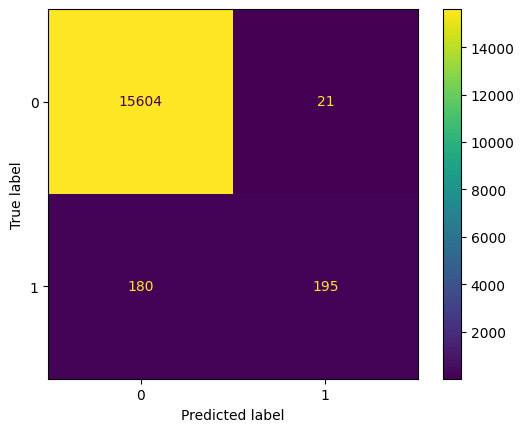

In [24]:
# plot confusion matrix
cm=confusion_matrix(data_temedian_y,pred)
display=ConfusionMatrixDisplay(cm)
display.plot()

Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.76')

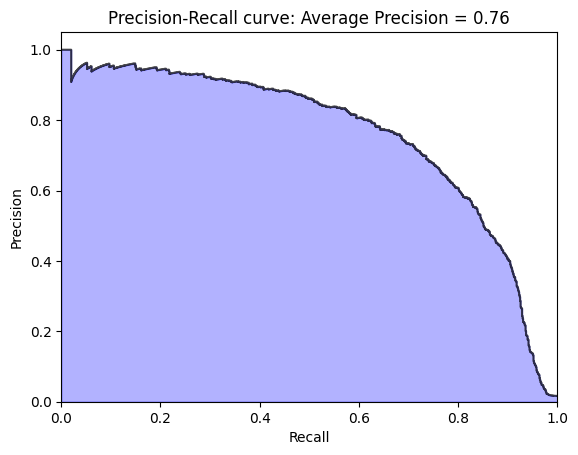

In [25]:
# precision and recall curve


preds = pd.concat([trainy,TotalPredictPro.loc[:,1]], axis=1)  # add two column to create a datafarme
preds.columns = ['trueLabel','prediction']
TotalPredictPro = preds.copy()
precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],preds['prediction'])
average_precision = average_precision_score(preds['trueLabel'],preds['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

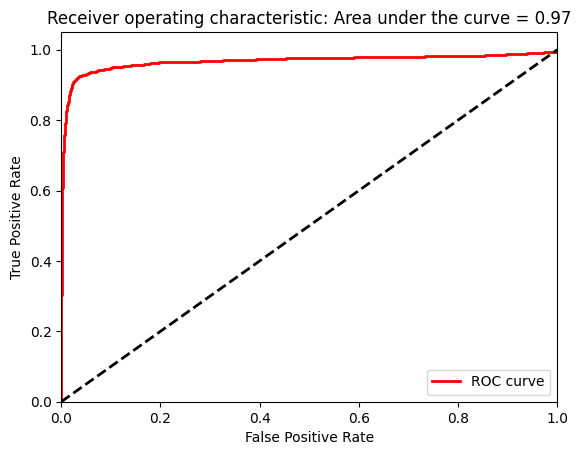

In [26]:
fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

# Random Forest

In [37]:
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier

In [28]:
# Number of trees in the forest:
n_estimators = 15
# Number of features to consider when looking for the best split:
max_features="sqrt"
# Maximum depth of the tree:
max_depth = 20
# Minimum number of samples required to split an internal node:
min_samples_split = 3
# Minimum number of samples required to be at a leaf node:
min_samples_leaf = 1
# Grow trees with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. 
max_leaf_nodes = None
# Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree:
bootstrap = False
# Whether to use out-of-bag samples to estimate the generalization score. Only available if bootstrap=True.
oob_score = False
# Number of jobs to run in parallel. (-1) means use all.
n_jobs = -1
# Random state
random_state = 2020
#-----------------------------------------------------------------
# Creating the classifier:
RFC = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                              max_leaf_nodes=max_leaf_nodes, bootstrap=bootstrap,oob_score=oob_score, n_jobs=n_jobs, random_state=random_state)

In [29]:
model1=RFC

trainScore=[]
valScore=[]
total_prob=pd.DataFrame(data=[],index=trainx.index,columns=[0,1])


for train_index,cv_index in k_fold.split(trainx,trainy):
    train_x_fold, x_cv_fold = trainx.iloc[train_index,:], trainx.iloc[cv_index,:]
    train_y_fold, y_cv_fold = trainy.iloc[train_index], trainy.iloc[cv_index]

    model1.fit(train_x_fold,train_y_fold)
    # let look at prediction probability of being 0(neg) or 1(pos) for training fold
    prob_train=model1.predict_proba(train_x_fold)
    loglosstrain=log_loss(train_y_fold,prob_train)
    trainScore.append(loglosstrain)

    # let look at prediction probability of being 0(neg) or 1(pos) for cv fold
    prob_cv=model1.predict_proba(x_cv_fold)
    loglosscv=log_loss(y_cv_fold,prob_cv)
    valScore.append(loglosscv)


    total_prob.loc[x_cv_fold.index,:]=model1.predict_proba(x_cv_fold)
    
    print("**************************************")
    print(f"Training Log Loss is {loglosstrain}")
    print(f"CV Log Loss is {loglosscv}")

pre_train_y=model1.predict_proba(trainx)
loglosstotal=log_loss(trainy,pre_train_y) 

print("************************************")
print(f"RFC log loss {loglosstotal}")


**************************************
Training Log Loss is 0.0029244177302208112
CV Log Loss is 0.022129822714520363
**************************************
Training Log Loss is 0.0018373338446028983
CV Log Loss is 0.023692150324856925
**************************************
Training Log Loss is 0.0017885258926313057
CV Log Loss is 0.0249803728286486
**************************************
Training Log Loss is 0.0017249260674170237
CV Log Loss is 0.02460981012297468
**************************************
Training Log Loss is 0.0017031844190197093
CV Log Loss is 0.021896772044625295
************************************
RFC log loss 0.00574190194414082


In [31]:
predict_RF=model1.predict(data_temedian_x)

In [32]:
print(classification_report(data_temedian_y,predict_RF))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     15625
         1.0       0.92      0.66      0.77       375

    accuracy                           0.99     16000
   macro avg       0.96      0.83      0.88     16000
weighted avg       0.99      0.99      0.99     16000



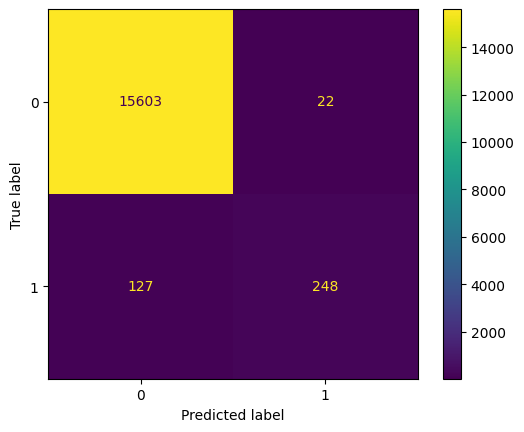

In [34]:

cm=confusion_matrix(data_temedian_y,predict_RF)
dis=ConfusionMatrixDisplay(cm)
dis.plot()

Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.85')

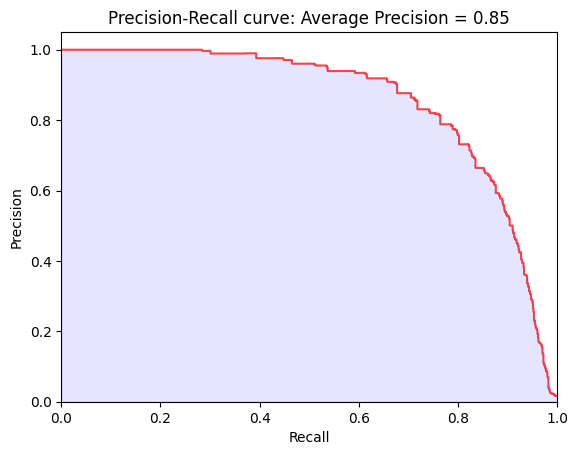

In [35]:
preds = pd.concat([trainy,total_prob.loc[:,1]], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsLogisticRegression = preds.copy()
precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],preds['prediction'])
average_precision = average_precision_score(preds['trueLabel'],preds['prediction'])

plt.step(recall, precision, color='r', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.1, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

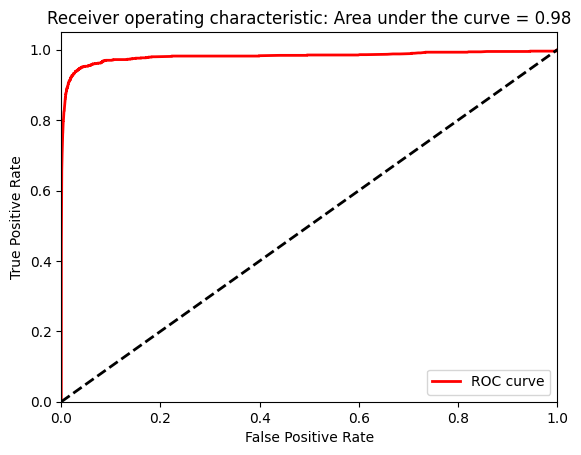

In [36]:
fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

# AdaBoost Implementation

In [38]:
# adaboost hyperparameters

n_estimators=20
learning_rate=0.0001
algorithm="SAMME.R"        #{‘SAMME’, ‘SAMME.R’}, default=’SAMME.R’

adaboost=AdaBoostClassifier(n_estimators=n_estimators,learning_rate=learning_rate,algorithm=algorithm,random_state=2020)

In [39]:
model1=adaboost

trainScore=[]
valScore=[]
TotalPredictPro_ada=pd.DataFrame(data=[],index=trainx.index,columns=[0,1])


for train_index,cv_index in k_fold.split(trainx,trainy):
    train_x_fold, x_cv_fold = trainx.iloc[train_index,:], trainx.iloc[cv_index,:]
    train_y_fold, y_cv_fold = trainy.iloc[train_index], trainy.iloc[cv_index]

    model1.fit(train_x_fold,train_y_fold)
    # let look at prediction probability of being 0(neg) or 1(pos) for training fold
    prob_train=model1.predict_proba(train_x_fold)
    loglosstrain=log_loss(train_y_fold,prob_train)
    trainScore.append(loglosstrain)

    # let look at prediction probability of being 0(neg) or 1(pos) for cv fold
    prob_cv=model1.predict_proba(x_cv_fold)
    loglosscv=log_loss(y_cv_fold,prob_cv)
    valScore.append(loglosscv)


    TotalPredictPro_ada.loc[x_cv_fold.index,:]=model1.predict_proba(x_cv_fold)
    
    print("**************************************")
    print(f"Training Log Loss is {loglosstrain}")
    print(f"CV Log Loss is {loglosscv}")

pre_train_y=model1.predict_proba(trainx)
loglosstotal=log_loss(trainy,pre_train_y) 

print("************************************")
print(f"RFC log loss {loglosstotal}")


**************************************
Training Log Loss is 0.04736297346749011
CV Log Loss is 0.0495364065101294
**************************************
Training Log Loss is 0.04910820867784961
CV Log Loss is 0.04710728080505792
**************************************
Training Log Loss is 0.047556690794146754
CV Log Loss is 0.04915480576303495
**************************************
Training Log Loss is 0.04849335588330366
CV Log Loss is 0.05013478657072737
**************************************
Training Log Loss is 0.04788011320813812
CV Log Loss is 0.04831557789233027
************************************
RFC log loss 0.04796720614497656


In [44]:
predict_ad=model1.predict(data_temedian_x)

In [45]:
print(classification_report(data_temedian_y,predict_ad))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     15625
         1.0       0.00      0.00      0.00       375

    accuracy                           0.98     16000
   macro avg       0.49      0.50      0.49     16000
weighted avg       0.95      0.98      0.96     16000



C:\Users\ganes\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ganes\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ganes\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


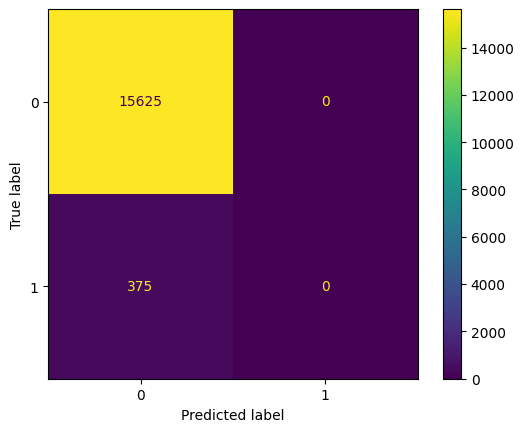

In [46]:
cm=confusion_matrix(data_temedian_y,predict_ad)
disp=ConfusionMatrixDisplay(cm)
disp.plot()

Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.30')

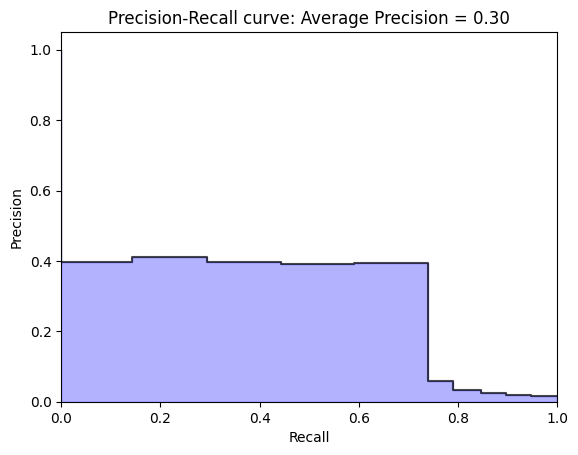

In [47]:
# precision and recall curve


preds_ada = pd.concat([trainy,TotalPredictPro_ada.loc[:,1]], axis=1)  # add two column to create a datafarme
preds_ada.columns = ['trueLabel','prediction']
TotalPredictPro_ada = preds_ada.copy()
precision, recall, thresholds = precision_recall_curve(preds_ada['trueLabel'],preds_ada['prediction'])
average_precision = average_precision_score(preds_ada['trueLabel'],preds_ada['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

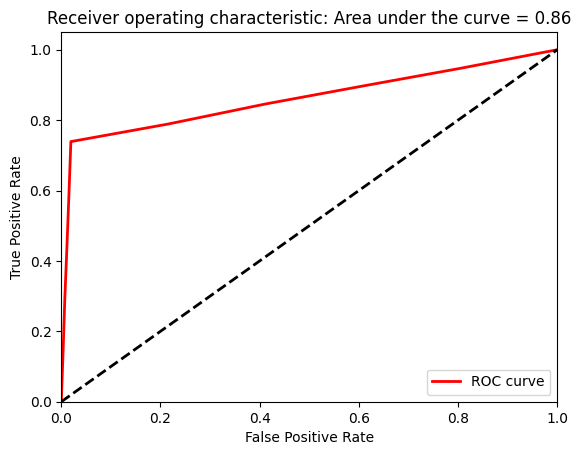

In [48]:
fpr, tpr, thresholds = roc_curve(preds_ada['trueLabel'],preds_ada['prediction'])
areaUnderROC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

# Improved Adaboost Implementation

In [57]:
# adaboost hyperparameters

n_estimators=60
learning_rate=1 
algorithm="SAMME.R"        #{‘SAMME’, ‘SAMME.R’}, default=’SAMME.R’


adaboost=AdaBoostClassifier(n_estimators=n_estimators,learning_rate=learning_rate,algorithm=algorithm,random_state=2020)

In [58]:
model1=adaboost

trainScore=[]
valScore=[]
TotalPredictPro_ada=pd.DataFrame(data=[],index=trainx.index,columns=[0,1])


for train_index,cv_index in k_fold.split(trainx,trainy):
    train_x_fold, x_cv_fold = trainx.iloc[train_index,:], trainx.iloc[cv_index,:]
    train_y_fold, y_cv_fold = trainy.iloc[train_index], trainy.iloc[cv_index]

    model1.fit(train_x_fold,train_y_fold)
    # let look at prediction probability of being 0(neg) or 1(pos) for training fold
    prob_train=model1.predict_proba(train_x_fold)
    loglosstrain=log_loss(train_y_fold,prob_train)
    trainScore.append(loglosstrain)

    # let look at prediction probability of being 0(neg) or 1(pos) for cv fold
    prob_cv=model1.predict_proba(x_cv_fold)
    loglosscv=log_loss(y_cv_fold,prob_cv)
    valScore.append(loglosscv)


    TotalPredictPro_ada.loc[x_cv_fold.index,:]=model1.predict_proba(x_cv_fold)
    
    print("**************************************")
    print(f"Training Log Loss is {loglosstrain}")
    print(f"CV Log Loss is {loglosscv}")

pre_train_y=model1.predict_proba(trainx)
adaboostlosstotal=log_loss(trainy,pre_train_y) 

print("************************************")
print(f"RFC log loss {adaboostlosstotal}")


**************************************
Training Log Loss is 0.5903994347089068
CV Log Loss is 0.589390379226267
**************************************
Training Log Loss is 0.5745122317626653
CV Log Loss is 0.5757413570490245
**************************************
Training Log Loss is 0.587435942838918
CV Log Loss is 0.5869284568531817
**************************************
Training Log Loss is 0.608792770428496
CV Log Loss is 0.609077419914474
**************************************
Training Log Loss is 0.5882656603471904
CV Log Loss is 0.5883696706612123
************************************
RFC log loss 0.5882864624099949


In [59]:
predict_ad=model1.predict(data_temedian_x)

In [60]:
print(classification_report(data_temedian_y,predict_ad))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     15625
         1.0       0.84      0.57      0.68       375

    accuracy                           0.99     16000
   macro avg       0.92      0.79      0.84     16000
weighted avg       0.99      0.99      0.99     16000



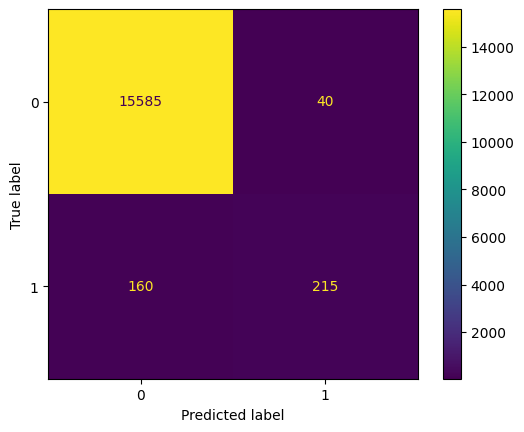

In [61]:
# plot the confusion matrix
cm=confusion_matrix(data_temedian_y,predict_ad)
disp=ConfusionMatrixDisplay(cm)
disp.plot()

Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.81')

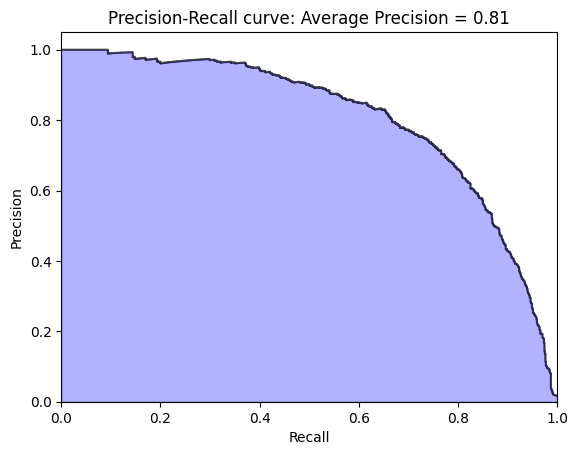

In [55]:
# precision and recall curve


preds_ada = pd.concat([trainy,TotalPredictPro_ada.loc[:,1]], axis=1)  # add two column to create a datafarme
preds_ada.columns = ['trueLabel','prediction']
TotalPredictPro_ada = preds_ada.copy()
precision, recall, thresholds = precision_recall_curve(preds_ada['trueLabel'],preds_ada['prediction'])
average_precision = average_precision_score(preds_ada['trueLabel'],preds_ada['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

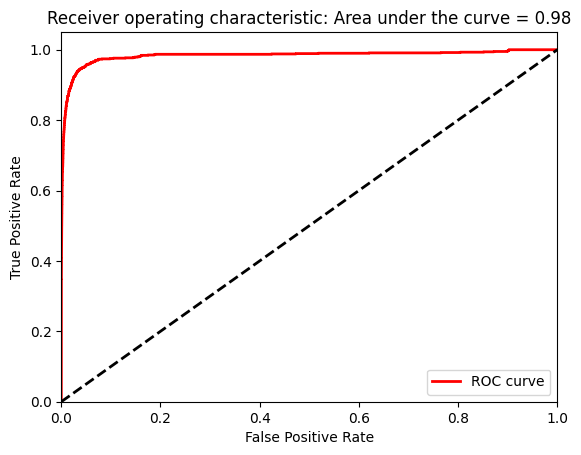

In [62]:
fpr, tpr, thresholds = roc_curve(preds_ada['trueLabel'],preds_ada['prediction'])
areaUnderROC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

# Comment on the Base models Performace
We have implemented the different model such as logistic regression, SVM,RF,adaboot. Maily to evalute the perfrmace of the models I have consider the accuarcy of model and the f1_score. f1_score gives the overall infomation about the precision  and recall when f1_score is high ultimately we have good precisiona nd recall.

From the above implemetation the randomforest has performed well on the dataset with imputation.

Remark: upon decreasing the n_estimator in the adaboot the perfomance of model decreases.

# Implementation using Deep Learning with median imputation

# first define the models
the shape of data is 60000,163 as we ahve droped the 7 columns which had 70% null values

In [85]:
def B_model1():
    model = models.Sequential()
    model.add(layers.Dense(60, input_shape=(163,), activation='relu'))
    model.add(layers.Dense(30, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model    


In [86]:
def BN_model():
    model=models.Sequential()
    model.add(layers.Dense(60, input_shape=(163,), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(30,activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1,activation="sigmoid"))
    # compile the model
    model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
    return model
    

In [88]:
# Training the model using training data and validating it performance using validation dataset
for train_index,cv_index in k_fold.split(data_trmedian_x,data_trmedian_y):
    train_x_fold, x_cv_fold = data_trmedian_x.iloc[train_index,:], data_trmedian_x.iloc[cv_index,:]
    train_y_fold, y_cv_fold = data_trmedian_y.iloc[train_index], data_trmedian_y.iloc[cv_index]

    # When model fails to convert data from datafraem to tensor, so we convert first the to array
    train_x_fold=np.asarray(train_x_fold).astype(np.float32)
    train_y_fold=np.asarray(train_y_fold).astype(np.float32)
    x_cv_fold=np.asarray(x_cv_fold).astype(np.float32)
    y_cv_fold=np.asarray(y_cv_fold).astype(np.float32)

    # call the models
    base_model=B_model1()
    high_model=BN_model()

    
    history1=base_model.fit(train_x_fold,train_y_fold,batch_size=1000,epochs=60,validation_data=(x_cv_fold,y_cv_fold),verbose=0)
    history2=high_model.fit(train_x_fold,train_y_fold,batch_size=1000,epochs=60,validation_data=(x_cv_fold,y_cv_fold),verbose=0)


In [89]:
# create the datafraem to store the model history
df_base=pd.DataFrame(history1.history)
df_base["epochs"]=history1.epoch


df_high=pd.DataFrame(history2.history)
df_high["epochs"]=history2.epoch

# Performance Evalution

In [98]:
# predcition on the test data and the 0.5 theshold can be chnaged 
predict_base=base_model.predict(data_temedian_x)
predict_base=predict_base>0.5
predict_high_BN=high_model.predict(data_temedian_x)
predict_high_BN=predict_high_BN>0.5

500/500 [==============================] - 1s 1ms/step


In [92]:
# print the classification report and it for B_model
print(classification_report(data_temedian_y,predict_base))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     15625
         1.0       0.94      0.62      0.75       375

    accuracy                           0.99     16000
   macro avg       0.97      0.81      0.87     16000
weighted avg       0.99      0.99      0.99     16000



In [99]:
# classification report for the model BN_model
print(classification_report(data_temedian_y,predict_high_BN))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     15625
         1.0       0.94      0.45      0.61       375

    accuracy                           0.99     16000
   macro avg       0.97      0.73      0.80     16000
weighted avg       0.99      0.99      0.98     16000



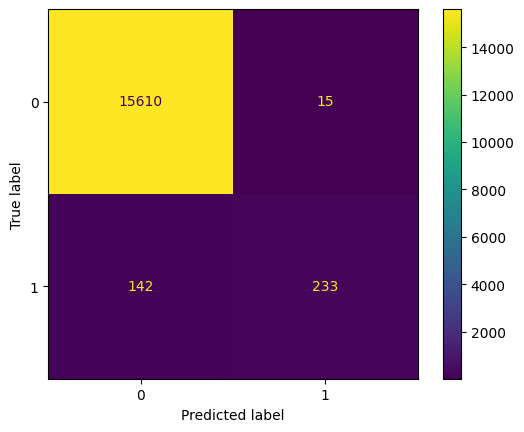

In [100]:
# confusion matrix for the B_model
cm=confusion_matrix(data_temedian_y,predict_base)
disp=ConfusionMatrixDisplay(cm)
disp.plot()

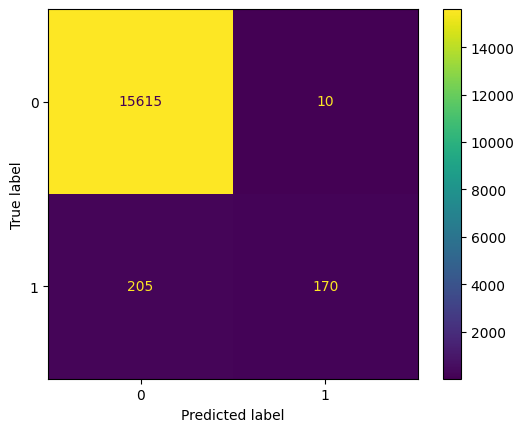

In [101]:
# confusion matrix for the B_model
cm=confusion_matrix(data_temedian_y,predict_high_BN)
disp=ConfusionMatrixDisplay(cm)
disp.plot()

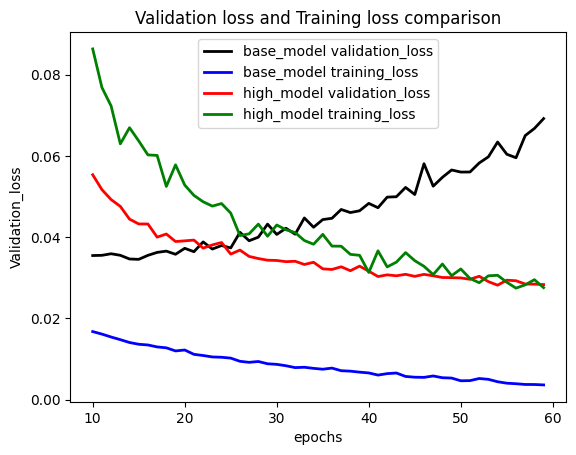

In [102]:
compare_val_loss(df_base,df_high)

Base model:

considering the validation loss and training curve for the base model, it is seen that they oppoiste o each other. When the training loss is decreasing the validation loss is increasing. Which is an indicator that model is not perfomrating good and it overfitts the data. The reason not enough complexity of model.

High_model:

the high model is performing well compare to the base model, also the both validation losss curve and trainining loss curve  is coincide each other. Which shows that the training loss and validation loss decreasing over the numver of epochs.

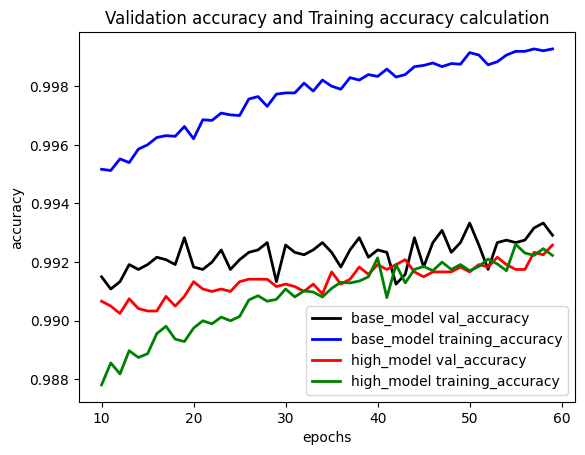

In [103]:
compare_accuracy_curve(df_base,df_high)

# Comment on the overall performance of this approach
The performace of any model can't be calculated based on the single parameter such as only considering the accuarcy, we must cinsider the other factors according the problem statement such as f1-score,precision, recall,ROC.

Mainly the f1-score and accuracy is important these are the parameters which shows that how the dataset is been classified.

The base model has shown the good f1-score and accuarcy wrt high model but it seems it is overfitting on that data. We can try implementation of different models.